# Estimate Sobol’ indices for the Ishigami function by a sampling method: a quick start guide to sensitivity analysis

### Analyse de la fonction Ishigami avec l'ensemble de codes dévelopés pour l'analyse de sensibilité sur les cahmps stochastiques.

#### Comparaison et corréctions

La même logique d'écriture de codes est utilisée que dans le script 'Demo Analyse de sensibilité poutre' : https://openturns.github.io/openturns/master/examples/reliability_sensitivity/sensitivity_sobol.html

In [52]:
# Voici les deux scripts destinés à gérer l'analyse de sensibilité sur les champs stochastiques
import NdGaussianProcessSensitivity as ngps
import NdGaussianProcessConstructor as ngpc
import NdGaussianProcessSensitivityIndices as ngpsi
# Classes utilitaires
import numpy                        as np
import openturns                    as ot
from   importlib                import reload 

In [53]:
# This is the formula used in the openTURNS example. 
formula = ['sin(X1) + 7. * sin(X2)^2 + 0.1 * X3^4 * sin(X1)']
input_names = ['X1', 'X2', 'X3']
g = ot.SymbolicFunction(input_names, formula)

# we have to modifiy the function, be cause it takes as an input a random vector, un-correlated
# in the case of our method, un-correlated inputs are clearly distinct. 
def gMod(X1,X2,X3):
    X = np.stack([X1,X2,X3]).T
    return g(X)

In [54]:
X = np.random.uniform(-np.pi,np.pi,[10,3])
assert gMod(X[...,0], X[...,1], X[...,2]) == g(X) ,""

Maintenant nous définissons nos variables d'entrée, avec les fonctions contenues dans notre méthode 

In [55]:
reload(ngpc)
reload(ngps)
lower  = -np.pi
upper  = np.pi
nameX1, nameX2, nameX3 = 'X1', 'X2', 'X3'
RV_X1 = ngpc.UniformDistribution(lower = lower, upper = upper, name = nameX1)
RV_X2 = ngpc.UniformDistribution(lower = lower, upper = upper, name = nameX2)
RV_X3 = ngpc.UniformDistribution(lower = lower, upper = upper, name = nameX3)

SyntaxError: invalid syntax (NdGaussianProcessConstructor.py, line 218)

In [56]:
# here we have to explicitely define our outputs
outputVariables = {'out1_name' :  #any name here is fine
                   {
                         'name'     : 'Y',
                         'position' : 0,   #Position in the ouput, if the output were a list
                         'shape'    : (1,)  
                    },
                  }

In [42]:
inputList    = [RV_X1, RV_X2, RV_X3]
soloFunction = sampleFunction = gMod #Easy in this case
size         = 100000

In [43]:
processSensitivityAnalysis = ngps.NdGaussianProcessSensitivityAnalysis(inputList, 
                                                                       outputVariables,
                                                                       sampleFunction,
                                                                       soloFunction,
                                                                       size)

Input Variables are (without Karhunen Loeve Decomposition) :
 ['X1', 'X2', 'X3'] 

Output Variables are :
 ['Y'] 



In [44]:
processSensitivityAnalysis.prepareSobolIndicesExperiment()

Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)
number of samples for sobol experiment =  500000 

input design is:  [[-0.6137944  -0.650022   -0.16762406]
 [-2.37004778 -1.49463999 -0.69587281]
 [-1.69214399  0.25436306 -2.49832556]
 ...
 [ 0.40406584  2.60042669  2.8741103 ]
 [ 1.80297034  1.25134382 -2.15802594]
 [ 1.79173671  1.0204666  -1.16056711]]


In [45]:
processSensitivityAnalysis.getOutputDesignAndPostprocess()

Converting list of outputs into matrix: 
Element  1  has shape  (500000, 1)
Final shape matrix:  (500000, 1)
Columns where nan :  [] 


No errors while processing, the function has returned no np.nan.



In [46]:
output = processSensitivityAnalysis.outputDesignList
output1 = output[0]

In [47]:
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 5)
import NdGaussianProcessSensitivityIndices as ngpsi
_=reload(ngpsi)

Populating the interactive namespace from numpy and matplotlib


/home/simady/anaconda/envs/stochastic_field_env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['size']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [50]:
S, Stot, varS, varStot = ngpsi.NdGaussianProcessSensitivityIndicesBase.getSobolIndices(output1, 100000)

There are 3 indices to get in (1,) dimensions with 1 elements
After centering, mean= [-4.60431693e-18] 
std=  [3.72892122]
After centering, mean= [-1.98951966e-18] 
std=  [3.72892122]
After centering, mean= [-6.25277607e-19] 
std=  [3.72892122]
After centering, mean= [3.80850906e-18] 
std=  [3.72892122]
After centering, mean= [-1.42108547e-18] 
std=  [3.72892122]
basic output shape is: (100000, 1)
output reshaped into matrix of shape (dim<=2)  [100000, 1]
data for variance calculus prepared 
 X_fo shape is (100000,) Y_fo shape is (100000,) 

Covariance is: [[205.91962414  50.76425079]
 [ 50.76425079 488.5111996 ]]
Sample mean is: [4.394771271348436, 13.94694660290871]
Psi mean is: [ 0.07170028 -0.02259321]
variance is: 1.1435105441597581e-05 

Covariance is: [[340.23092782 107.60365438]
 [107.60365438 488.5111996 ]]
Sample mean is: [6.059551371095844, 13.94694660290871]
Psi mean is: [-0.07170028  0.03115173]
variance is: 1.7424851831287946e-05 

basic output shape is: (100000, 1)
outpu

The output is scalar
The sensitivity is measured accordingly to the 3 input variables, namely:
 X1 and X2 and X3


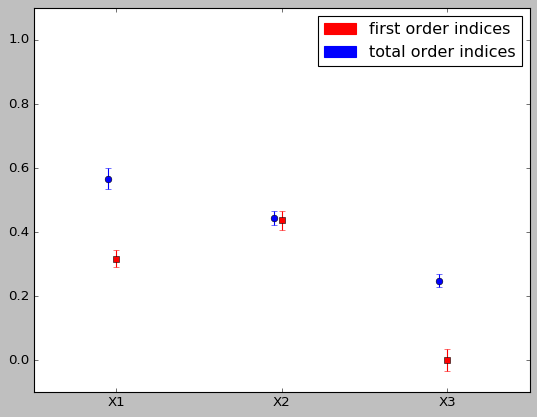

In [51]:
varNames = ['X1', 'X2', 'X3']
ngpsi.plotSobolIndicesWithErr(S, varS, varNames, 3, Stot, varStot)